In [0]:

# %pip install databricks-cli

In [0]:
# from databricks_cli.config import get_current_profile_from_config_file
# config = get_current_profile_from_config_file()

In [0]:
!pip install mlflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn import datasets
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, lasso_path, enet_path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

In [0]:
#load dataset

diab = datasets.load_diabetes()
X=diab.data
y=diab.target

np.random.seed(42)

In [0]:
Y=np.array([y]).transpose()
d=np.concatenate((X,Y),axis=1)

columns = ['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6','progression']
data=pd.DataFrame(d,columns=columns)

In [0]:
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [0]:
def plot_elastic(X,y,l1_ratio):
    eps=5e-3
    alpha_enet, coef_enet, _ =enet_path(X , y, eps=eps, l1_ratio=l1_ratio)
    global image

    fig= plt.figure()
    az=plt.gca()

    colors = cycle(['b','r','g','c','k'])
    neg_alpha_ents = -np.log10(alpha_enet)

    for coef_e , c in zip(coef_enet, colors):
        l1=plt.plot(neg_alpha_ents, coef_e, c=c, linestyle = '--')
        plt.xlabel('Log alpa')
        plt.ylabel('Coefficients')

        title="Elaticnet "+ str(l1_ratio)
        plt.title(title)
        plt.axis('tight')
        image=fig
        fig.savefig('Elasticnet_path.png')
        plt.close(fig)
        return image

In [0]:
def metric_for_model(actual, pred):

    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae= mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)

    return rmse, mae, r2

In [0]:
def train_diab_model(data, l1_alpha, l1_ratio):
    train, test = train_test_split(data)
    train_x = train.drop(['progression'], axis=1)
    test_x = test.drop(['progression'], axis=1)
    train_y = train['progression'] # replace round brackets with square brackets
    test_y = test['progression'] # replace round brackets with square brackets

    #

    if float(l1_alpha) is None:
        alpha = 0.05
    else:
        alpha = float(l1_alpha)

    if float(l1_ratio) is None:
        l1_score = 0.05
    else:
        l1_score = float(l1_ratio)

    with mlflow.start_run() as run: # variable 'run' has not been defined yet, you must create a new tracking run with mlflow.start_run()
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_score, random_state=42)
        lr.fit(train_x, train_y)
        lr_predict = lr.predict(test_x)

        (rmse, mae, r2) = metric_for_model(test_y, lr_predict)

        print("Elastic Model (alpha = %f, l1_ratio=%f" % (alpha, l1_score))
        print("RMSE : %s" % rmse)
        print("R2 score : %s" % r2)
        print("MAE : %s" % mae)

        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1 ration", l1_score)
        mlflow.log_param("RMSE", rmse)
        mlflow.log_param("r2", r2)
        mlflow.log_param("mae", mae)
        mlflow.sklearn.log_model(lr, "model")

        modelpath = "/Users/harsh.tripathi@iiitb.ac.in/img/nnn_model-%f-%f" % (alpha, l1_score)
        mlflow.sklearn.save_model(lr, modelpath)

        image = plot_elastic(X,y, l1_score)
        mlflow.log_artifacts('Elasticnet_path.png')
        best_run = run.info
        return best_run


In [0]:
train_diab_model(data, 0.01, 0.01)

Elastic Model (alpha = 0.010000, l1_ratio=0.010000
RMSE : 61.85950061118989
R2 score : 0.30799051018831824
MAE : 52.872566029521316


2024/01/28 18:11:00 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.8.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts: 0it [00:00, ?it/s]

<RunInfo: artifact_uri='dbfs:/databricks/mlflow-tracking/2389151175013304/a94c13a61a8a4dccb4c6b0f0ba266cf1/artifacts', end_time=None, experiment_id='2389151175013304', lifecycle_stage='active', run_id='a94c13a61a8a4dccb4c6b0f0ba266cf1', run_name='colorful-finch-549', run_uuid='a94c13a61a8a4dccb4c6b0f0ba266cf1', start_time=1706465459596, status='RUNNING', user_id=''>

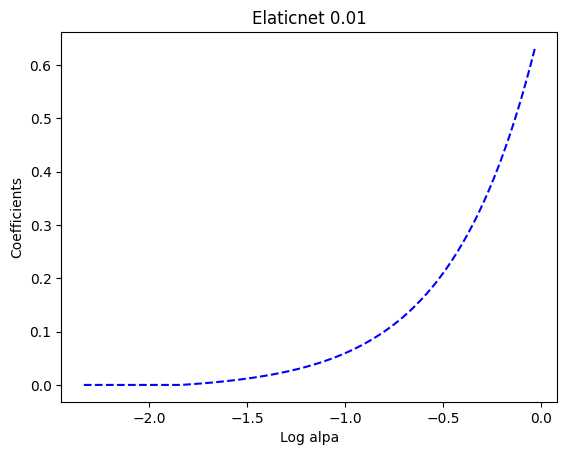

In [0]:
display(image)

Elastic Model (alpha = 4.650000, l1_ratio=0.210000
RMSE : 78.41040260732004
R2 score : -0.0026694073382835803
MAE : 64.92732164792803


2024/01/28 18:11:07 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.8.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts: 0it [00:00, ?it/s]

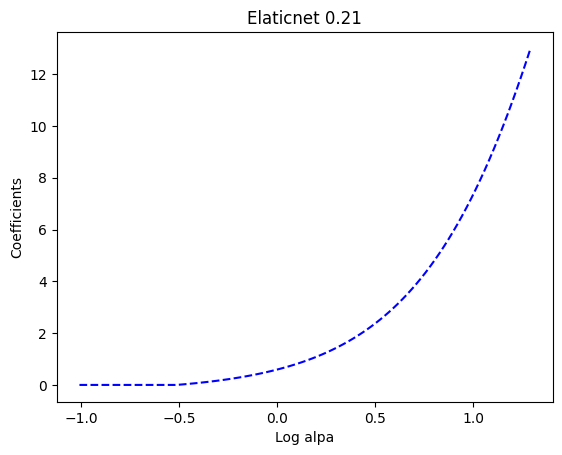

In [0]:
mdl = train_diab_model(data, 4.65, 0.21)
display(image)

In [0]:
model_name = "diab"

In [0]:
def print_model_info(mod):
    for i in mod:
        print("name {}".format(i.name))
        print("version {}".format(i.version))
        print("run id {}".format(i.run_id))
        print("current_stage {}".format(i.current_stage))

In [0]:
import time
client =  mlflow.tracking.MlflowClient()
try:
    client.create_registered_model(model_name)
except Exception as e:
    pass

model_version = client.create_model_version(model_name, f"{mdl.artifact_uri}/model", mdl.run_id)
time.sleep(3)



2024/01/28 18:11:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: diab, version 4


In [0]:
model_info = print_model_info(client.get_latest_versions(name=model_name))

name diab
version 3
run id a39902d944624f56a72317791d8d0a66
current_stage Staging
name diab
version 4
run id 50036fb3ba794a8b9a095fe321be89e4
current_stage None


In [0]:
client.transition_model_version_stage(model_name, model_version.version, stage="staging")

<ModelVersion: aliases=[], creation_timestamp=1706465473907, current_stage='Staging', description='', last_updated_timestamp=1706465483418, name='diab', run_id='50036fb3ba794a8b9a095fe321be89e4', run_link='', source='dbfs:/databricks/mlflow-tracking/2389151175013304/50036fb3ba794a8b9a095fe321be89e4/artifacts/model', status='READY', status_message='', tags={}, user_id='4490419882523069', version='4'>